# Causal Inference on the Breast Cancer dataset
In this notebook we will conduct causal learning on the Breast Cancer dataset. The following steps will be followed:
<ol>
    <li>Split data into training and hold-out set</li>
    <li>Create a causal graph using all training data and get the insights (this will be considered the ground truth)</li>
    <li>Create new causal graphs using increasing fractions of the data and compare with the ground truth graph. The comparison will be done using a Jaccard Similarity Index, measuring the intersection and union of the graph edges</li>
    <li>After reaching a stable causal graph, select only variables that point directly to the target variable</li>
</li>




## Import the Libraries

In [7]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import causalnex
import sys
import os
import mlflow
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IPython.display import Markdown, display, Image, display_html

from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
from causalnex.structure.notears import from_pandas
from causalnex.utils.network_utils import get_markov_blanket
from causalnex.structure import StructureModel
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE


### Load Data

In [5]:
bc_df=pd.read_csv('../data/clean_data.csv')
bc_df.drop(columns='Unnamed: 0', inplace=True)
bc_df.head()

,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,concavity_se,smoothness_worst,compactness_worst,concavity_worst,target
0,0.332480,0.014458,0.378881,0.448682,0.227262,0.224231,0.086580,0.383592,0.395177,0.362837,1
1,0.706526,0.299435,0.318447,0.223674,0.171853,0.089337,0.051599,0.381804,0.169795,0.211988,1
2,0.468684,0.304090,0.400749,0.360388,0.178921,0.221257,0.075401,0.376812,0.300284,0.280312,1
3,0.115843,0.198965,0.447359,0.311872,0.076694,0.299526,0.078825,0.504788,0.448843,0.302519,1
4,0.563779,0.140143,0.385181,0.415224,0.209280,0.150294,0.128560,0.391458,0.154318,0.285955,1


### Split the data into train and hold-out sets

In [8]:
# Select the x and y (features and target variables)
y= bc_df['target']
x = bc_df.drop('target', axis=1)

# Use sklearn to split the dataset into train and test set 80:20
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [9]:
print("shape of original dataset :", bc_df.shape)
print("shape of input - training set", x_train.shape)
print("shape of output - training set", y_train.shape)
print("shape of input - testing set", x_test.shape)
print("shape of output - testing set", y_test.shape)

shape of original dataset : (569, 11)
shape of input - training set (455, 10)
shape of output - training set (455,)
shape of input - testing set (114, 10)
shape of output - testing set (114,)


### Saving the train and test datasets to csv

In [14]:
#combine the train features and target into one dataframe
train_df = x_train.copy()
train_df['diagnosis'] = y_train

#combine the train features and target into one dataframe
test_df = x_test.copy()
test_df['diagnosis'] = y_test

#for testing
train_df.head()

,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,concavity_se,smoothness_worst,compactness_worst,concavity_worst,diagnosis
393,0.445567,0.273565,0.372229,0.423701,0.119480,0.169204,0.076673,0.335859,0.339912,0.362532,1
499,0.496371,0.300495,0.388701,0.395078,0.133647,0.148507,0.079050,0.382859,0.248540,0.318787,1
268,0.402297,0.317282,0.542330,0.131894,0.064290,0.211693,0.094367,0.518812,0.214973,0.229651,0
307,0.312242,0.518269,0.513877,0.028182,0.074665,0.064568,0.030374,0.592114,0.079352,0.038418,0
374,0.538235,0.364585,0.465052,0.101515,0.036216,0.173369,0.050039,0.440256,0.299824,0.182236,0


In [16]:
#saving the train and test sets to csv
train_df.to_csv("../data/train.csv")
test_df.to_csv("../data/test.csv")

### Feature Extraction

## Causal Analysis

First, we start by rejoining the features to the target variable and then label encode the target variable (<em>diagnosis</em>)

In [14]:
causal_df = selected_feat.copy()
causal_df["target"] = LabelEncoder().fit_transform(target_df)
causal_df.head()

,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,target
0,17.99,10.38,0.11840,0.3001,1.0950,0.04904,0.1622,0.6656,0.7119,0.4601,1
1,20.57,17.77,0.08474,0.0869,0.5435,0.01308,0.1238,0.1866,0.2416,0.2750,1
2,19.69,21.25,0.10960,0.1974,0.7456,0.04006,0.1444,0.4245,0.4504,0.3613,1
3,11.42,20.38,0.14250,0.2414,0.4956,0.07458,0.2098,0.8663,0.6869,0.6638,1
4,20.29,14.34,0.10030,0.1980,0.7572,0.02461,0.1374,0.2050,0.4000,0.2364,1


We then divided the dataset into ratios of 20, 40, 60, 10 and 100 percent

In [15]:
factor = len(causal_df)/100
causal_20 = causal_df.sample(int(20*factor), random_state=11)
print(f"size of causal_20 : {len(causal_20)}")
causal_40 = causal_df.sample(int(40*factor), random_state=11)
print(f"size of causal_40 : {len(causal_40)}")
causal_60 = causal_df.sample(int(60*factor), random_state=11)
print(f"size of causal_60 : {len(causal_60)}")
causal_80 = causal_df.sample(int(80*factor), random_state=11)
print(f"size of causal_80 : {len(causal_80)}")
print(f"size of causal_100 : {len(causal_df)}")

size of causal_20 : 113
size of causal_40 : 227
size of causal_60 : 341
size of causal_80 : 455
size of causal_100 : 569


<b>Generate the ground truth structure</b>

In [16]:
ground_truth = from_pandas(causal_df, tabu_parent_nodes=["target"])

<b>Generate the structures from fractional datasets</b>

In [17]:
sm20 = from_pandas(causal_20, tabu_parent_nodes=["target"])
sm40 = from_pandas(causal_40, tabu_parent_nodes=["target"])
sm60 = from_pandas(causal_60, tabu_parent_nodes=["target"])
sm80 = from_pandas(causal_80, tabu_parent_nodes=["target"])

## Plotting and comparing stability of the Graphs at different ratios

In [18]:
utils.plot_graph(ground_truth, 0.8, True, "groud_truth_graph.png")

INFO:utils:treshold successfully applied
C:\Users\wakur\anaconda3\envs\causal-inference\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: node 'radius_mean', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


### Selecting the nodes and edges

In [19]:
feat = ['diagnosis', 'perimeter_worst', 'area_worst', 'radius_worst', 'concave points_worst', 'concave points_mean', 'perimeter_mean', 'area_mean', 'radius_mean', 'area_se', 'concavity_mean', 'concavity_worst', 'perimeter_se', 'radius_se', 'compactness_worst', 'compactness_mean', 'texture_worst', 'concave points_se', 'smoothness_worst', 'texture_mean', 'symmetry_worst', 'concavity_se', 'smoothness_mean', 'symmetry_mean', 'compactness_se', 'fractal_dimension_worst', 'fractal_dimension_se', 'texture_se', 'fractal_dimension_mean', 'symmetry_se', 'smoothness_se']
len(feat)

31

In [20]:
x = data[feat[:29]]
x['diagnosis'] = x['diagnosis'].apply(lambda x: 1 if x == "M" else 0)
x.head(5)

C:\Users\wakur\AppData\Local\Temp\ipykernel_8464\1331229971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['diagnosis'] = x['diagnosis'].apply(lambda x: 1 if x == "M" else 0)


,diagnosis,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,...,texture_mean,symmetry_worst,concavity_se,smoothness_mean,symmetry_mean,compactness_se,fractal_dimension_worst,fractal_dimension_se,texture_se,fractal_dimension_mean
0,1,184.60,2019.0,25.38,0.2654,0.14710,122.80,1001.0,17.99,153.40,...,10.38,0.4601,0.05373,0.11840,0.2419,0.04904,0.11890,0.006193,0.9053,0.07871
1,1,158.80,1956.0,24.99,0.1860,0.07017,132.90,1326.0,20.57,74.08,...,17.77,0.2750,0.01860,0.08474,0.1812,0.01308,0.08902,0.003532,0.7339,0.05667
2,1,152.50,1709.0,23.57,0.2430,0.12790,130.00,1203.0,19.69,94.03,...,21.25,0.3613,0.03832,0.10960,0.2069,0.04006,0.08758,0.004571,0.7869,0.05999
3,1,98.87,567.7,14.91,0.2575,0.10520,77.58,386.1,11.42,27.23,...,20.38,0.6638,0.05661,0.14250,0.2597,0.07458,0.17300,0.009208,1.1560,0.09744
4,1,152.20,1575.0,22.54,0.1625,0.10430,135.10,1297.0,20.29,94.44,...,14.34,0.2364,0.05688,0.10030,0.1809,0.02461,0.07678,0.005115,0.7813,0.05883


In [21]:
sm = from_pandas(x.iloc[:, :9], tabu_parent_nodes=['diagnosis'],)

In [22]:
def vis_sm(sm):
  viz = plot_structure(
      sm,
      graph_attributes={"scale": "2.0", 'size': 2.5},
      all_node_attributes=NODE_STYLE.WEAK,
      all_edge_attributes=EDGE_STYLE.WEAK)
  return Image(viz.draw(format='png'))

C:\Users\wakur\anaconda3\envs\causal-inference\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: node 'diagnosis', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


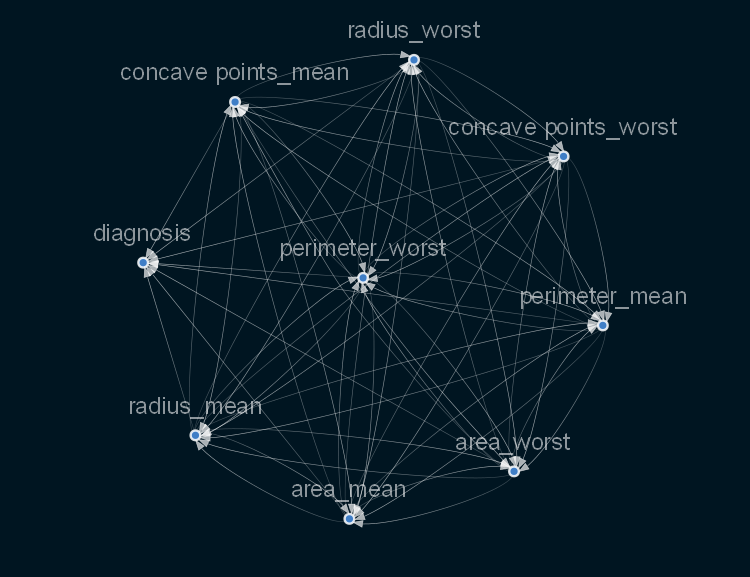

In [23]:
vis_sm(sm)

In [24]:
pip install Pygraphviz

Note: you may need to restart the kernel to use updated packages.


In [25]:
import torch
rint(torch.version.cuda)
print(torch.cuda.is_available())

NameError: name 'rint' is not defined